In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
import pandas as pd
import joblib
import numpy as np

In [2]:
# Set random seed so this part is reproducible
# https://www.random.org/ 2023-08-09
np.random.seed(3866)

In [3]:
with open("../../../data/pickles/su2c-elastic-net-model.joblib", "rb") as f:
    elastic_net_model = joblib.load(f)
    
with open("../../../data/pickles/su2c-linear-svm-model.joblib", "rb") as f:
    linear_svm_model = joblib.load(f)
    
with open("../../../data/pickles/su2c-rbf-svm-model.joblib", "rb") as f:
    rbf_svm_model = joblib.load(f)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
clin = pd.read_feather("../../../data/tcga/TCGA-recount3-metadata-2023-02-22.feather")
clin = clin.set_index('index')

In [5]:
sig = pd.read_csv("../../../data/enrichment/TCGA-LUAD-MinMaxNorm-2023-08-28-response-subtype-clusters.tsv",
                  sep='\t')
sig.index = [x.replace(".", "-").lstrip("X") for x in sig.index.values]

In [6]:
clin = clin.reindex(sig.index)

In [7]:
clin

,study,tcga.gdc_cases.project.name,tcga.cgc_sample_sample_type,tcga.tcga_barcode
5b1e3218-61b6-4d10-8815-c1038c739f05,LUAD,Lung Adenocarcinoma,Primary Tumor,TCGA-55-7911-01A-11R-2170-07
c3257122-09a9-449c-be4a-107703def60c,LUAD,Lung Adenocarcinoma,Primary Tumor,TCGA-44-2656-01A-02R-0946-07
6a4c997f-2f28-4888-8d4c-c2dc8b108520,LUAD,Lung Adenocarcinoma,Solid Tissue Normal,TCGA-44-2657-11A-01R-1758-07
dc7450dc-4a7a-48ee-bef1-f5e5b46db020,LUAD,Lung Adenocarcinoma,Primary Tumor,TCGA-44-5644-01A-21R-2039-07
642c8ec2-4829-4b2b-af17-a6b52a793e26,LUAD,Lung Adenocarcinoma,Primary Tumor,TCGA-55-8616-01A-11R-2403-07
...,...,...,...,...
f59229d8-3570-4d7a-aed9-4ad6f128c6f9,LUAD,Lung Adenocarcinoma,Primary Tumor,TCGA-55-8094-01A-11R-2241-07
82f42146-d66d-488e-a7c8-bb338bf5d5fb,LUAD,Lung Adenocarcinoma,Primary Tumor,TCGA-62-8399-01A-21R-2326-07
ea8e7e8a-ef5b-4f87-b344-657b397aeefc,LUAD,Lung Adenocarcinoma,Primary Tumor,TCGA-91-6840-01A-11R-1949-07
8690fa0f-9c1c-4d97-813a-3fb56827fbfc,LUAD,Lung Adenocarcinoma,Recurrent Tumor,TCGA-50-5066-02A-11R-2090-07


In [8]:
meta = pd.read_excel("../../../data/tcga/1-s2.0-S1074761318301213-mmc2.xlsx",
                     index_col=0)

In [9]:
pd.read_csv("../../../data/tcga/LUAD.clin.merged.txt",
                     index_col=0,
                     sep='\t').T

/tmp/ipykernel_73221/367684668.py:1: DtypeWarning: Columns (41,258) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("../../../data/tcga/LUAD.clin.merged.txt",


admin.batch_number,admin.bcr,admin.day_of_dcc_upload,admin.disease_code,admin.file_uuid,admin.month_of_dcc_upload,admin.patient_withdrawal.withdrawn,admin.project_code,admin.year_of_dcc_upload,patient.additional_studies,patient.additional_studies.additional_study.disease_code,...,patient.tumor_samples.tumor_sample.tumor_histologies.tumor_histology.tumor_morphology_percentage,patient.tumor_samples.tumor_sample.tumor_locations.laterality,patient.tumor_samples.tumor_sample.tumor_locations.tumor_focality,patient.tumor_samples.tumor_sample.tumor_locations.tumor_location.site_of_disease,patient.tumor_samples.tumor_sample.tumor_locations.tumor_location.site_of_disease_description,patient.tumor_samples.tumor_sample.tumor_locations.tumor_location.site_of_disease_text,patient.tumor_samples.tumor_sample.tumor_necrosis_percent,patient.tumor_samples.tumor_sample.tumor_nuclei_percent,patient.tumor_samples.tumor_sample.tumor_weight,patient.tumor_samples.tumor_sample.vessel_used
52.72.0,nationwide children's hospital,21,luad,170e5252-9526-4816-be6d-7f2d528ead6d,1,false,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,lung,upper,NaN,20,70,100,cryovial
58.75.0,nationwide children's hospital,21,luad,63047bab-bdb1-46ac-af80-3cb2c08cc291,1,false,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,lung,upper,NaN,20,70,100,cryovial
119.74.0,nationwide children's hospital,21,luad,62dc5247-6baa-42e1-b597-f05111c0759c,1,false,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,lung,lower,inferior pulmonary lobe right s vi,20,70,100,cryovial
144.68.0,nationwide children's hospital,21,luad,d0d98146-8056-4417-bacd-0f7e914e4f43,1,false,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,lung,lower,lower pulmonary lobe right,20,70,100,cryovial
58.75.0.1,nationwide children's hospital,21,luad,8fdfffd4-bfd9-44a6-815d-cdc96d91550d,1,false,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,lung,lower,lower pulmonary lobe right,20,70,100,cryovial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278.54.0.18,nationwide children's hospital,21,luad,70f2abcc-9360-4689-b902-847ec4f984f7,1,false,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,lung,upper,NaN,0,80,100,other
278.54.0.19,nationwide children's hospital,21,luad,4248dc7d-78f7-406c-ad24-a6504a13c676,1,false,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,lung,upper,NaN,0,90,100,other
406.35.0.11,nationwide children's hospital,21,luad,eac16c92-5a42-49ad-90bf-d812c82d2451,1,false,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,lung,upper,NaN,0,100,150,other
278.54.0.20,nationwide children's hospital,21,luad,402acffe-b10f-4df4-8a2a-c47758b485c9,1,false,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,lung,lower,NaN,0,60,105,cryovial


In [10]:
meta

,TCGA Study,Immune Subtype,TCGA Subtype,Leukocyte Fraction,Stromal Fraction,Intratumor Heterogeneity,TIL Regional Fraction,Proliferation,Wound Healing,Macrophage Regulation,...,T Cells CD8,T Cells Follicular Helper,T Cells gamma delta,T Cells Regulatory Tregs,Lymphocytes,Neutrophils.1,Eosinophils.1,Mast Cells,Dendritic Cells,Macrophages
TCGA Participant Barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-01-0639,OV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0007,GBM,NaN,GBM_LGG.Classic-like,0.047660,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0011,GBM,NaN,GBM_LGG.LGm6-GBM,0.062099,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0023,GBM,NaN,GBM_LGG.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0025,GBM,NaN,GBM_LGG.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZJ-AAXJ,CESC,C2,NaN,0.190520,0.28,0.06,3.508290,1.0591,0.4380,-0.5428,...,0.109746,0.158487,0.053922,0.025416,0.588338,0.001046,0.0,0.016717,0.218868,0.175031
TCGA-ZJ-AB0I,CESC,C2,NaN,0.059910,0.10,0.03,2.915626,0.9968,0.3120,-0.5787,...,0.227673,0.082950,0.000000,0.050475,0.475620,0.001589,0.0,0.082539,0.028535,0.411717
TCGA-ZN-A9VU,MESO,C2,NaN,0.272642,0.39,0.01,NaN,-0.4574,-0.1410,0.5686,...,0.074590,0.049620,0.000000,0.000000,0.470148,0.000000,0.0,0.123572,0.027675,0.378605


In [11]:
clin = clin[clin["tcga.cgc_sample_sample_type"] == "Primary Tumor"]

In [12]:
def extract_patient(x):
    return '-'.join(x.split("-")[:3])

clin["patient"] = clin["tcga.tcga_barcode"].apply(extract_patient)

/tmp/ipykernel_73221/3217481632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clin["patient"] = clin["tcga.tcga_barcode"].apply(extract_patient)


In [13]:
sig = sig.reindex(clin.index)

In [14]:
elastic_net_test_yhat = elastic_net_model.predict(sig.loc[:, ~(sig.columns.str.contains("Up") | sig.columns.str.contains("Down"))].values)

In [15]:
linear_svm_model_yhat = linear_svm_model.predict(sig.loc[:, ~(sig.columns.str.contains("Up") | sig.columns.str.contains("Down"))].values)

linear_svm_model_yhat

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,

In [16]:
for k, v in meta.iloc[0, :].items():
    print(k, v)

TCGA Study OV
Immune Subtype nan
TCGA Subtype nan
Leukocyte Fraction nan
Stromal Fraction nan
Intratumor Heterogeneity nan
TIL Regional Fraction nan
Proliferation nan
Wound Healing nan
Macrophage Regulation nan
Lymphocyte Infiltration Signature Score nan
IFN-gamma Response nan
TGF-beta Response nan
SNV Neoantigens nan
Indel Neoantigens nan
Silent Mutation Rate nan
Nonsilent Mutation Rate nan
Number of Segments nan
Fraction Altered nan
Aneuploidy Score nan
Homologous Recombination Defects nan
BCR Evenness nan
BCR Shannon nan
BCR Richness nan
TCR Shannon nan
TCR Richness nan
TCR Evenness nan
CTA Score nan
Th1 Cells nan
Th2 Cells nan
Th17 Cells nan
OS nan
OS Time nan
PFI nan
PFI Time nan
B Cells Memory nan
B Cells Naive nan
Dendritic Cells Activated nan
Dendritic Cells Resting nan
Eosinophils nan
Macrophages M0 nan
Macrophages M1 nan
Macrophages M2 nan
Mast Cells Activated nan
Mast Cells Resting nan
Monocytes nan
Neutrophils nan
NK Cells Activated nan
NK Cells Resting nan
Plasma Cells nan

In [17]:
clin["OS"] = clin["patient"].map(meta["OS"])

clin["OS Time"] = clin["patient"].map(meta["OS Time"])

clin["TIL Regional Fraction"] = clin["patient"].map(meta["TIL Regional Fraction"])

clin["Nonsilent Mutation Rate"] = clin["patient"].map(meta["Nonsilent Mutation Rate"])

/tmp/ipykernel_73221/2078837811.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clin["OS"] = clin["patient"].map(meta["OS"])
/tmp/ipykernel_73221/2078837811.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clin["OS Time"] = clin["patient"].map(meta["OS Time"])
/tmp/ipykernel_73221/2078837811.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [18]:
sig["OS"] = sig.index.map(clin["OS"])
sig["OS"] = sig["OS"].astype(bool)
sig["OS Time"] = sig.index.map(clin["OS Time"])
sig["ElasticNetPrediction"] = elastic_net_test_yhat
sig["LinearSVMPrediction"] = linear_svm_model_yhat
sig["Nonsilent Mutation Rate"] = sig.index.map(clin["Nonsilent Mutation Rate"])
sig["TIL Regional Fraction"] = sig.index.map(clin["TIL Regional Fraction"])
sig = sig.dropna()

In [19]:
sig.to_csv("../../../data/tcga/TCGA-LUAD-response-sig-surv-data.tsv",
           sep='\t')

In [20]:
sig

,Response Subtype Cluster 0 ratio-cluster-0,Response Subtype Cluster 0 ratio-cluster-0 Up,Response Subtype Cluster 0 ratio-cluster-0 Down,Response Subtype Cluster 0 ratio-cluster-1,Response Subtype Cluster 0 ratio-cluster-1 Up,Response Subtype Cluster 0 ratio-cluster-1 Down,Response Subtype Cluster 1 ratio-cluster-0,Response Subtype Cluster 1 ratio-cluster-0 Up,Response Subtype Cluster 1 ratio-cluster-0 Down,Response Subtype Cluster 1 ratio-cluster-1,...,Response Subtype Cluster 2 ratio-cluster-0 Down,Response Subtype Cluster 2 ratio-cluster-1,Response Subtype Cluster 2 ratio-cluster-1 Up,Response Subtype Cluster 2 ratio-cluster-1 Down,OS,OS Time,ElasticNetPrediction,LinearSVMPrediction,Nonsilent Mutation Rate,TIL Regional Fraction
5b1e3218-61b6-4d10-8815-c1038c739f05,0.155930,-0.150132,0.306062,-0.067477,-0.071235,0.003758,0.226589,0.115466,0.111123,0.076205,...,-0.044448,0.789688,0.318315,0.471373,False,537.0,1,1,5.911560,20.131397
c3257122-09a9-449c-be4a-107703def60c,-0.183758,-0.144341,-0.039417,-0.194109,-0.062676,-0.131433,0.101566,0.110503,-0.008937,-0.238929,...,-0.039633,0.501794,0.156048,0.345746,False,1429.0,1,1,20.856665,8.271923
dc7450dc-4a7a-48ee-bef1-f5e5b46db020,-0.574609,-0.183254,-0.391355,-0.029170,0.011701,-0.040872,0.247646,0.137436,0.110210,0.303876,...,-0.029496,0.173279,-0.074521,0.247800,False,863.0,1,1,26.120645,3.308966
642c8ec2-4829-4b2b-af17-a6b52a793e26,0.296852,-0.136712,0.433564,0.139728,0.042581,0.097147,0.123014,0.071921,0.051093,0.573275,...,-0.080121,-0.484258,-0.075674,-0.408583,False,48.0,0,1,12.039601,9.201643
520354a4-9c4f-4cde-8e73-004e76d92a2e,-0.564070,-0.079567,-0.484503,-0.112351,-0.040118,-0.072233,0.018634,0.042607,-0.023973,-0.249887,...,0.009089,0.466235,0.078093,0.388142,False,44.0,1,1,11.605397,18.096182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e75d87af-dc22-4a00-8dac-ede1d242b3e5,-0.389354,-0.193925,-0.195429,-0.161992,-0.073703,-0.088289,0.049472,0.085815,-0.036343,0.025275,...,-0.071621,0.420993,0.063039,0.357954,False,1893.0,1,1,3.224874,24.761383
3e400da6-7337-4af6-8ee7-e642de9f0ef0,0.445632,-0.042396,0.488028,0.142186,0.021202,0.120983,0.079467,-0.008669,0.088136,0.555338,...,-0.055402,0.135808,-0.084075,0.219883,True,2681.0,1,1,2.813850,1.470144
e820fd60-318f-4094-8d28-5305305508f9,0.414993,0.013536,0.401457,-0.104315,-0.074773,-0.029541,0.155535,0.044007,0.111528,-0.086684,...,-0.081019,0.345364,0.028197,0.317167,False,0.0,0,0,6.426331,9.198526
f59229d8-3570-4d7a-aed9-4ad6f128c6f9,0.287365,-0.212659,0.500024,-0.121180,-0.020245,-0.100935,0.276748,0.134451,0.142297,0.611688,...,0.015272,-0.406704,-0.174377,-0.232327,False,541.0,0,0,11.762494,1.051920


Text(0.5, 0, 'time $t$')

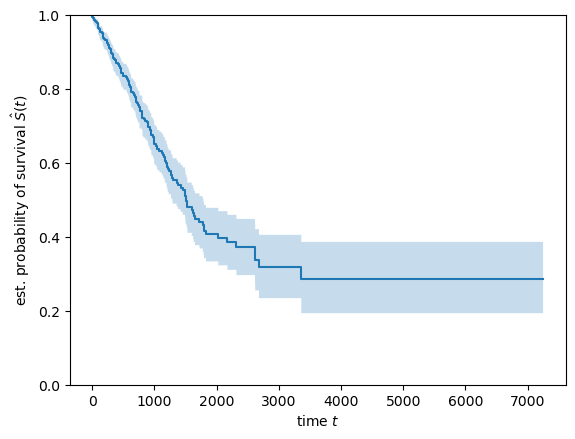

In [21]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    sig["OS"], sig["OS Time"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [22]:
from sksurv.datasets import load_veterans_lung_cancer, get_x_y

data_x, data_y = get_x_y(sig, attr_labels=["OS", "OS Time"], pos_label=True)

In [23]:
data_x

,Response Subtype Cluster 0 ratio-cluster-0,Response Subtype Cluster 0 ratio-cluster-0 Up,Response Subtype Cluster 0 ratio-cluster-0 Down,Response Subtype Cluster 0 ratio-cluster-1,Response Subtype Cluster 0 ratio-cluster-1 Up,Response Subtype Cluster 0 ratio-cluster-1 Down,Response Subtype Cluster 1 ratio-cluster-0,Response Subtype Cluster 1 ratio-cluster-0 Up,Response Subtype Cluster 1 ratio-cluster-0 Down,Response Subtype Cluster 1 ratio-cluster-1,...,Response Subtype Cluster 2 ratio-cluster-0,Response Subtype Cluster 2 ratio-cluster-0 Up,Response Subtype Cluster 2 ratio-cluster-0 Down,Response Subtype Cluster 2 ratio-cluster-1,Response Subtype Cluster 2 ratio-cluster-1 Up,Response Subtype Cluster 2 ratio-cluster-1 Down,ElasticNetPrediction,LinearSVMPrediction,Nonsilent Mutation Rate,TIL Regional Fraction
5b1e3218-61b6-4d10-8815-c1038c739f05,0.155930,-0.150132,0.306062,-0.067477,-0.071235,0.003758,0.226589,0.115466,0.111123,0.076205,...,0.318538,0.362986,-0.044448,0.789688,0.318315,0.471373,1,1,5.911560,20.131397
c3257122-09a9-449c-be4a-107703def60c,-0.183758,-0.144341,-0.039417,-0.194109,-0.062676,-0.131433,0.101566,0.110503,-0.008937,-0.238929,...,0.282670,0.322304,-0.039633,0.501794,0.156048,0.345746,1,1,20.856665,8.271923
dc7450dc-4a7a-48ee-bef1-f5e5b46db020,-0.574609,-0.183254,-0.391355,-0.029170,0.011701,-0.040872,0.247646,0.137436,0.110210,0.303876,...,-0.291196,-0.261700,-0.029496,0.173279,-0.074521,0.247800,1,1,26.120645,3.308966
642c8ec2-4829-4b2b-af17-a6b52a793e26,0.296852,-0.136712,0.433564,0.139728,0.042581,0.097147,0.123014,0.071921,0.051093,0.573275,...,-0.241467,-0.161345,-0.080121,-0.484258,-0.075674,-0.408583,0,1,12.039601,9.201643
520354a4-9c4f-4cde-8e73-004e76d92a2e,-0.564070,-0.079567,-0.484503,-0.112351,-0.040118,-0.072233,0.018634,0.042607,-0.023973,-0.249887,...,0.374236,0.365147,0.009089,0.466235,0.078093,0.388142,1,1,11.605397,18.096182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e75d87af-dc22-4a00-8dac-ede1d242b3e5,-0.389354,-0.193925,-0.195429,-0.161992,-0.073703,-0.088289,0.049472,0.085815,-0.036343,0.025275,...,0.257117,0.328738,-0.071621,0.420993,0.063039,0.357954,1,1,3.224874,24.761383
3e400da6-7337-4af6-8ee7-e642de9f0ef0,0.445632,-0.042396,0.488028,0.142186,0.021202,0.120983,0.079467,-0.008669,0.088136,0.555338,...,-0.406479,-0.351078,-0.055402,0.135808,-0.084075,0.219883,1,1,2.813850,1.470144
e820fd60-318f-4094-8d28-5305305508f9,0.414993,0.013536,0.401457,-0.104315,-0.074773,-0.029541,0.155535,0.044007,0.111528,-0.086684,...,-0.354574,-0.273555,-0.081019,0.345364,0.028197,0.317167,0,0,6.426331,9.198526
f59229d8-3570-4d7a-aed9-4ad6f128c6f9,0.287365,-0.212659,0.500024,-0.121180,-0.020245,-0.100935,0.276748,0.134451,0.142297,0.611688,...,-0.326900,-0.342173,0.015272,-0.406704,-0.174377,-0.232327,0,0,11.762494,1.051920


In [24]:
data_y

array([(False, 5.370e+02), (False, 1.429e+03), (False, 8.630e+02),
       (False, 4.800e+01), (False, 4.400e+01), (False, 3.070e+02),
       (False, 5.510e+02), (False, 8.720e+02), ( True, 3.361e+03),
       ( True, 1.499e+03), (False, 8.960e+02), ( True, 7.010e+02),
       ( True, 2.318e+03), (False, 5.910e+02), ( True, 5.860e+02),
       (False, 3.261e+03), ( True, 1.026e+03), (False, 4.350e+02),
       (False, 5.920e+02), (False, 2.560e+02), (False, 4.550e+02),
       (False, 1.125e+03), (False, 2.261e+03), (False, 8.390e+02),
       (False, 8.520e+02), (False, 1.650e+02), (False, 2.590e+03),
       ( True, 5.800e+01), (False, 4.150e+02), (False, 7.300e+02),
       (False, 4.090e+02), (False, 4.350e+02), ( True, 2.740e+02),
       (False, 4.460e+02), ( True, 7.190e+02), ( True, 1.622e+03),
       (False, 8.640e+02), (False, 4.765e+03), ( True, 9.520e+02),
       (False, 8.060e+02), ( True, 1.379e+03), (False, 5.000e+01),
       ( True, 1.167e+03), (False, 1.840e+02), (False, 6.900e+

In [25]:
data_x_numeric = OneHotEncoder().fit_transform(data_x)

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

/opt/conda/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=6.76937e-21): result may not be accurate.
  delta = solve(
/opt/conda/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.16664e-20): result may not be accurate.
  delta = solve(
/opt/conda/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.00789e-20): result may not be accurate.
  delta = solve(
/opt/conda/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.22756e-20): result may not be accurate.
  delta = solve(


CoxPHSurvivalAnalysis()

In [26]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

Response Subtype Cluster 0 ratio-cluster-0         1.631545
Response Subtype Cluster 0 ratio-cluster-0 Up     -3.664682
Response Subtype Cluster 0 ratio-cluster-0 Down   -2.058671
Response Subtype Cluster 0 ratio-cluster-1         2.156462
Response Subtype Cluster 0 ratio-cluster-1 Up      1.505333
Response Subtype Cluster 0 ratio-cluster-1 Down   -2.539594
Response Subtype Cluster 1 ratio-cluster-0        -2.663791
Response Subtype Cluster 1 ratio-cluster-0 Up      6.356396
Response Subtype Cluster 1 ratio-cluster-0 Down    1.447022
Response Subtype Cluster 1 ratio-cluster-1         0.113675
Response Subtype Cluster 1 ratio-cluster-1 Up      0.814264
Response Subtype Cluster 1 ratio-cluster-1 Down   -0.174592
Response Subtype Cluster 1 ratio-cluster-2         5.995187
Response Subtype Cluster 1 ratio-cluster-2 Up     -6.992927
Response Subtype Cluster 1 ratio-cluster-2 Down   -5.191253
Response Subtype Cluster 2 ratio-cluster-0         5.177057
Response Subtype Cluster 2 ratio-cluster

In [27]:
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x_numeric.values, data_y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

Response Subtype Cluster 1 ratio-cluster-0 Up      0.588814
Response Subtype Cluster 1 ratio-cluster-2         0.588413
Response Subtype Cluster 2 ratio-cluster-1 Up      0.586431
Response Subtype Cluster 0 ratio-cluster-0 Up      0.584884
Response Subtype Cluster 2 ratio-cluster-0 Up      0.582386
Response Subtype Cluster 1 ratio-cluster-0         0.581676
Response Subtype Cluster 2 ratio-cluster-0         0.577826
Response Subtype Cluster 1 ratio-cluster-2 Down    0.577367
Response Subtype Cluster 1 ratio-cluster-2 Up      0.574824
Response Subtype Cluster 2 ratio-cluster-1 Down    0.569369
TIL Regional Fraction                              0.568178
Response Subtype Cluster 1 ratio-cluster-1 Up      0.566253
Response Subtype Cluster 1 ratio-cluster-0 Down    0.558438
Response Subtype Cluster 0 ratio-cluster-1 Down    0.548927
Response Subtype Cluster 1 ratio-cluster-1         0.545055
Response Subtype Cluster 0 ratio-cluster-1         0.544413
LinearSVMPrediction                     

In [28]:
len(data_x_numeric)

478